## 主成分分析

## 結論  
・各主成分同士は無相関  
①
⇒RMSE_train_pca 0.811703069465103に対してRMSE_test_pca 1.0199176165753883とRMSEはよりその差が開いた。  
⇒変数削減により汎化性能が上昇するかと思われたが逆に低下した  
※ちなみに選択する主成分の数を増やすとよりその差が開く  
仮説  
・外れ値も除去したほうが良かった？  
・元の特徴量は８個とそんなに多くないのでより特徴量が多いデータでなら変わる？  
・他のモデル（決定木系）なら汎化性能の上昇が狙える？(各主成分とtargetの間に相関がみられるわけではないので線形回帰は不適合？)  

②  
⇒10分割交差検証で第5主成分までの特徴量を使ってRMSEを算出した結果RMSE＝0.8570318473053554になった。
⇒線形回帰だけでなくLightGBMでもその汎化性能が下がった。

In [53]:
import sklearn.datasets
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as gbm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#乳がんデータセット
data = sklearn.datasets.load_breast_cancer()
feature = data.data
target = data.target

In [3]:
df_train = pd.DataFrame(feature, columns=data.feature_names)
df_train['target'] = target
df_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


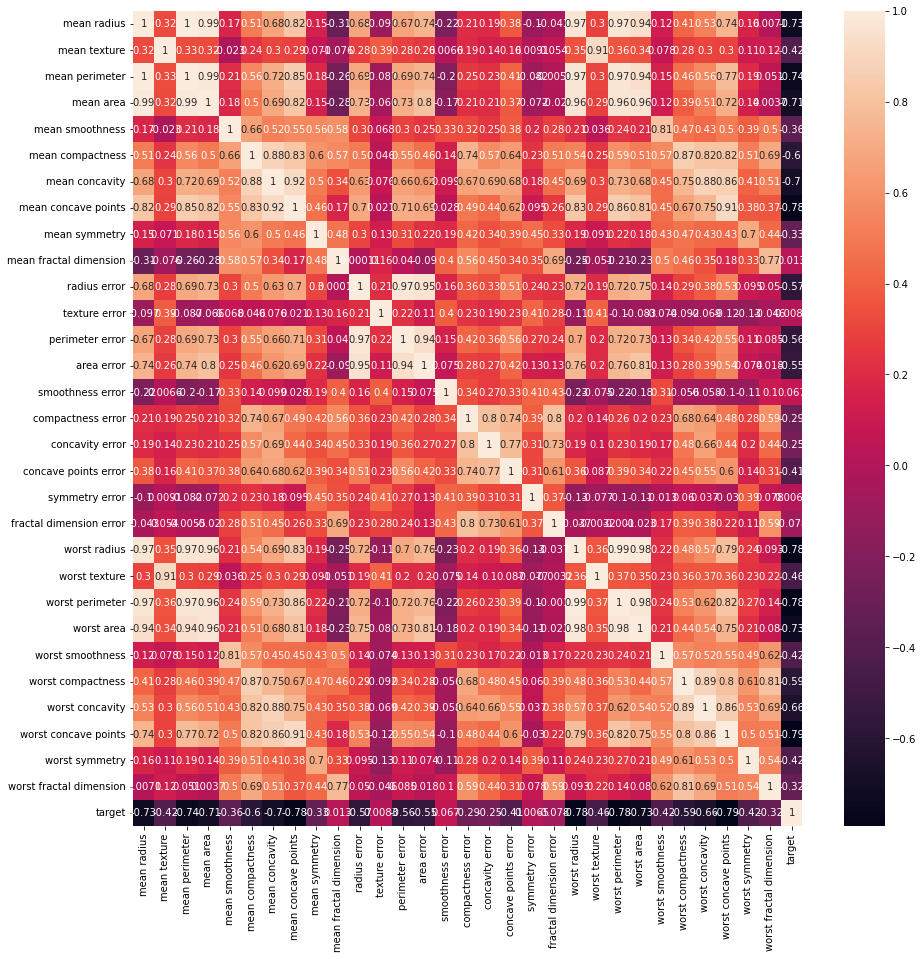

In [4]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

In [5]:
#配列に変換
x = df_train.loc[:,'mean radius':'worst fractal dimension'].values

In [6]:
#標準化
ss=StandardScaler()
x_std = ss.fit_transform(x)

In [7]:
#主成分分析
pca = PCA()
x_pca = pca.fit_transform(x_std)
#データフレームに格納
df_pca = pd.DataFrame(x_pca)

In [8]:
df_pca

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,...,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,...,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,...,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,...,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,...,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,-0.035471,0.987929,0.256989,...,0.006888,-0.067000,0.088590,0.107898,0.219520,-0.122900,0.159198,0.009853,0.007119,-0.001415
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,-1.113360,-0.105207,-0.108632,...,-0.009802,0.019563,-0.055405,0.086135,0.001197,0.065889,-0.068512,-0.023575,-0.027486,-0.010419
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0.341887,0.393917,0.520877,...,-0.036592,0.063352,-0.200312,-0.044819,0.002429,0.007095,-0.023691,-0.002578,0.006706,0.003770
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,-0.280239,-0.542035,-0.089296,...,0.140648,-0.042478,0.168820,-0.195969,0.377830,-0.198192,-0.027409,-0.068086,-0.084163,-0.023783


主成分同士の相関係数はかなり低い

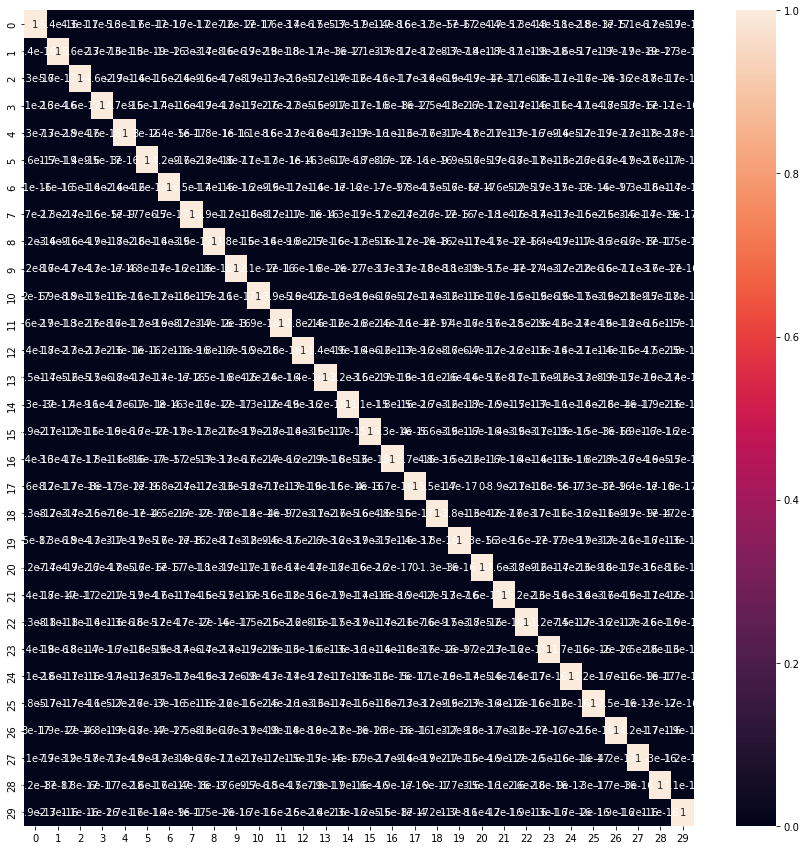

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(df_pca.corr(), annot=True)
plt.show()

In [10]:
#主成分の寄与率 第一主成分から
pca.explained_variance_ratio_

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04, 2.30015463e-04, 5.29779290e-05,
       2.49601032e-05, 4.43482743e-06])

In [11]:
#主成分の累積寄与率
np.cumsum(pca.explained_variance_ratio_)

array([0.44272026, 0.63243208, 0.72636371, 0.79238506, 0.84734274,
       0.88758796, 0.9100953 , 0.92598254, 0.93987903, 0.95156881,
       0.961366  , 0.97007138, 0.97811663, 0.98335029, 0.98648812,
       0.98915022, 0.99113018, 0.99288414, 0.9945334 , 0.99557204,
       0.99657114, 0.99748579, 0.99829715, 0.99889898, 0.99941502,
       0.99968761, 0.99991763, 0.99997061, 0.99999557, 1.        ])

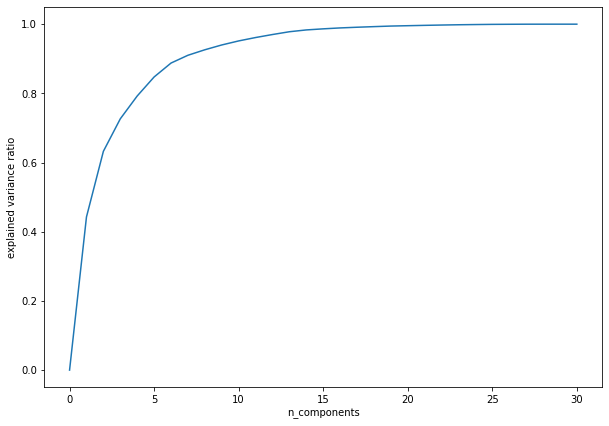

In [12]:
#累積寄与率をグラフ化
plt.figure(figsize=(10,7))
#np.hstack 配列を横（列方向）に結合
plt.plot(np.hstack([0, pca.explained_variance_ratio_.cumsum()]))
plt.xlabel('n_components')
plt.ylabel('explained variance ratio')
plt.show()

In [13]:
#第一主成分の因子負荷量
pca.components_[0,:]

array([0.21890244, 0.10372458, 0.22753729, 0.22099499, 0.14258969,
       0.23928535, 0.25840048, 0.26085376, 0.13816696, 0.06436335,
       0.20597878, 0.01742803, 0.21132592, 0.20286964, 0.01453145,
       0.17039345, 0.15358979, 0.1834174 , 0.04249842, 0.10256832,
       0.22799663, 0.10446933, 0.23663968, 0.22487053, 0.12795256,
       0.21009588, 0.22876753, 0.25088597, 0.12290456, 0.13178394])

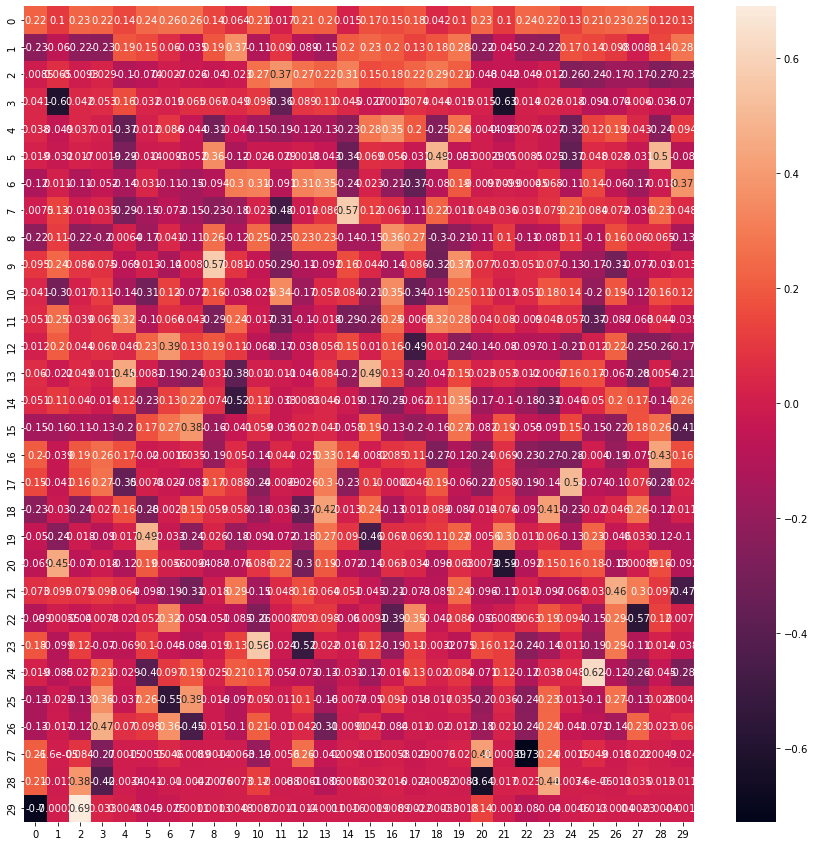

In [14]:
#因子負荷量をヒートマップ化 0=第一主成分
plt.figure(figsize=(15,15))
sns.heatmap(pca.components_, annot=True)
plt.show()

## California Housing

In [15]:
data_2 = sklearn.datasets.fetch_california_housing()
features = data_2.data
target_2 = data_2.target

In [16]:
df_train_2 = pd.DataFrame(features, columns=data_2.feature_names)
df_train_2['target']=target_2
df_train_2

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [17]:
#配列に変換
x_2 = df_train_2.loc[:,'MedInc':'Longitude'].values

In [18]:
#標準化
ss=StandardScaler()
x_2_std = ss.fit_transform(x_2)

In [19]:
#主成分分析
pca_2 = PCA()
x_pca_2 = pca_2.fit_transform(x_2_std)
#データフレームに格納
df_pca_2 = pd.DataFrame(x_pca_2)

In [20]:
df_pca_2

,0,1,2,3,4,5,6,7
0,1.882704,-0.503362,-0.314134,-2.555093,0.128040,0.485177,0.091226,-0.137812
1,1.371120,-0.121406,1.905258,-1.872984,-0.267430,0.605123,0.263086,-0.182221
2,2.086868,-0.501136,-0.937245,-2.100133,0.370032,1.158676,-0.295159,0.169800
3,1.575801,-1.239495,-1.025957,-1.286721,0.318956,0.977902,0.091039,-0.080535
4,1.591206,-1.345264,-1.249171,-0.450778,0.293612,0.865664,-0.159976,0.227928
...,...,...,...,...,...,...,...,...
20635,1.386779,-1.296137,0.054262,1.063026,-0.163868,-0.738947,-0.470517,-0.386192
20636,1.875219,-0.671533,0.155700,0.644612,-0.208383,-1.262269,-0.321725,-0.401329
20637,1.402357,-1.096426,0.567135,1.090397,-0.326347,-1.052189,-0.420289,-0.290166
20638,1.542943,-1.059408,0.365472,0.968799,-0.323242,-1.121581,-0.349867,-0.304425


<AxesSubplot:>

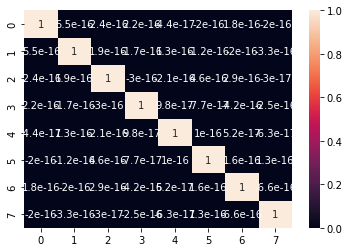

In [21]:
#主成分同士の相関係数は低そう
sns.heatmap(df_pca_2.corr(), annot=True)

In [22]:
#主成分の寄与率　第一主成分から
pca_2.explained_variance_ratio_

array([0.25336868, 0.23516245, 0.15888635, 0.12887971, 0.12538195,
       0.0824225 , 0.01020022, 0.00569814])

In [23]:
#累積寄与率
np.cumsum(pca_2.explained_variance_ratio_)

array([0.25336868, 0.48853113, 0.64741747, 0.77629718, 0.90167913,
       0.98410164, 0.99430186, 1.        ])

In [24]:
#因子負荷量を特徴量ごとにデータフレーム格納
pca_components = pd.DataFrame(pca_2.components_, columns=df_train_2.loc[:,'MedInc':'Longitude'].columns)
pca_components

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.077462,0.007318,0.439142,0.399996,-0.171783,-0.014644,0.568364,-0.536974
1,0.229879,-0.260786,0.546687,0.501850,0.100626,0.002621,-0.374011,0.422387
2,0.218222,-0.627551,-0.063999,-0.191848,0.650375,0.157727,0.192600,-0.180824
3,-0.885294,-0.109898,-0.046402,0.338144,0.283207,0.004918,0.062214,0.059846
4,-0.002603,0.222936,0.029852,0.050922,0.008078,0.972669,-0.022761,0.011807
5,0.149818,0.683931,0.095054,0.086854,0.675226,-0.169410,-0.042069,-0.082551
6,0.169238,-0.081035,-0.530662,0.531566,-0.031676,0.003246,-0.431797,-0.461698
7,-0.242271,-0.044846,0.458814,-0.379875,-0.013170,0.008959,-0.554415,-0.526165


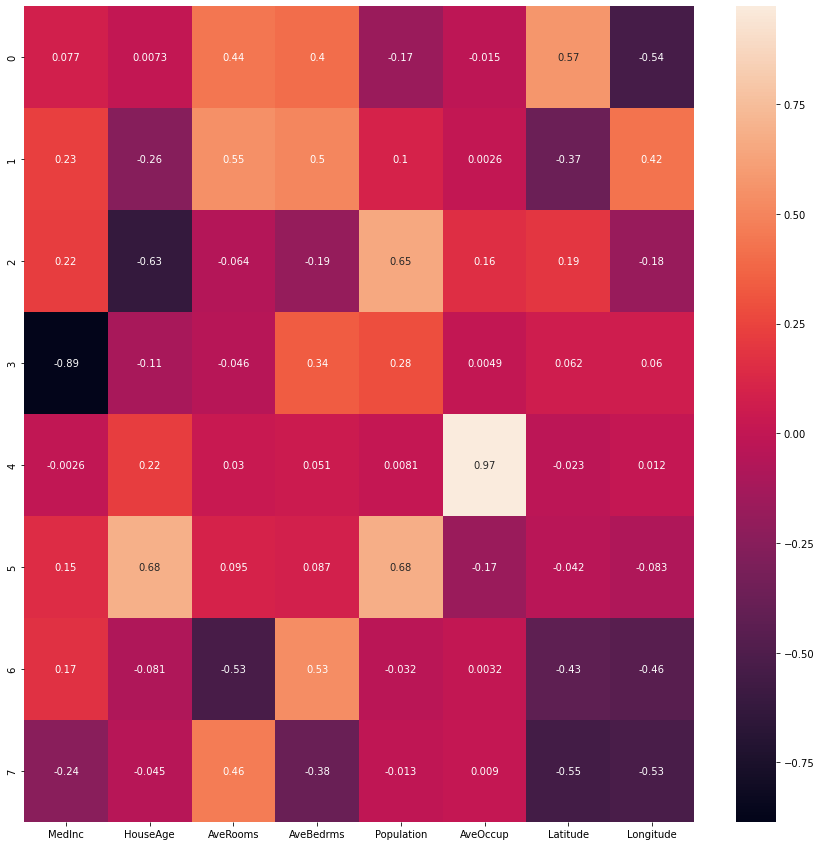

In [25]:
#因子負荷量をヒートマップ化 0=第一主成分
plt.figure(figsize=(15,15))
sns.heatmap(pca_components, annot=True)
plt.show()

※外れ値も除去しておく  
①普通に線形回帰、lightgbm⇒RMSEを算出（ホールドアウト法）  
②訓練データ数を1000件にし、ハイバリアンス状態を作る。その後主成分を選択し線形回帰。変数削減によりバリアンスが低下（汎化性能上昇）しているかチェック  

In [26]:
california=sklearn.datasets.fetch_california_housing()
feature_pca = california.data
target_pca = california.target

In [27]:
#ホールドアウト
x_train, x_test, y_train, y_test = train_test_split(feature_pca, target_pca, train_size=1000, shuffle=True, random_state=0)

In [28]:
#trainデータ：1000件 testデータ：残り
df_train_3 = pd.DataFrame(x_train, columns=california.feature_names)
df_train_3['target']=y_train
df_test_3 = pd.DataFrame(x_test, columns=california.feature_names)
df_test_3['target']=y_test

線形回帰⇒trainとtestそれぞれのRMSEを算出  
RMSE(train)<RMSE(test)になるはず

In [29]:
#スケーリング
ss=StandardScaler()
x_train_std = ss.fit_transform(x_train)
ss_2 = StandardScaler()
x_test_std = ss_2.fit_transform(x_test)

In [30]:
#線形回帰分析インスタンス作成
lr=LinearRegression()
lr.fit(x_train_std, y_train)

LinearRegression()

In [31]:
#trainに対する予測値、RMSE
y_train_pred = lr.predict(x_train_std)
print('RMSE_train', mean_squared_error(y_train, y_train_pred, squared=False))

RMSE_train 0.639103757603548


In [32]:
#testに対する予測値、RMSE
y_test_pred = lr.predict(x_test_std)
print('RMSE_test', mean_squared_error(y_test, y_test_pred, squared=False))

RMSE_test 0.7579396800216464


⇒やはりRMSE(train)<RMSE(test)になった

In [33]:
#x_trainとx_testを行方向に結合(全データでまとめてPCAをするため)
x = np.concatenate([x_train, x_test], axis=0)

In [34]:
#ｘを標準化
ss_3 = StandardScaler()
x_std = ss_3.fit_transform(x)

In [35]:
#pcaインスタンス⇒変換
pca_5 = PCA()
x_pca = pca_5.fit_transform(x_std)

In [36]:
#新しい特徴量（主成分）データフレームに格納
df_pca_3 = pd.DataFrame(x_pca, columns=['pca_1','pca_2','pca_3','pca_4','pca_5','pca_6','pca_7','pca_8'])
y = np.concatenate([y_train, y_test], axis=0) #ここでy_trainとy_testも結合しておく
df_pca_3['target']=y
df_pca_3

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,target
0,0.953232,0.007991,1.776658,-0.064424,-0.416072,-1.001955,-0.028877,-0.006862,1.46400
1,-0.334774,2.739497,0.283922,-3.403668,-0.069920,-0.343880,-0.040967,-0.056074,5.00001
2,1.954813,0.638632,0.861813,-3.655632,-0.125642,-0.037501,0.403920,-0.202265,5.00001
3,-1.920174,0.525941,-0.079073,1.201019,-0.114059,-0.474270,0.261574,0.054607,1.00000
4,0.015774,1.508770,-0.751671,1.751432,-0.253608,-1.558877,-0.381886,-0.950995,0.32900
...,...,...,...,...,...,...,...,...,...
20635,-0.129656,0.964109,0.292647,-1.050648,-0.056653,0.329902,0.149053,0.237044,5.00001
20636,-0.796854,0.550800,-1.407153,-0.346730,0.189675,0.190265,-0.499072,0.053643,1.34800
20637,0.223098,-0.707593,-0.364712,0.160806,0.097493,0.068758,-0.456065,-0.051519,0.69600
20638,-1.092724,0.440553,0.493736,0.865341,-0.472341,-1.639529,0.633698,-0.154259,1.62500


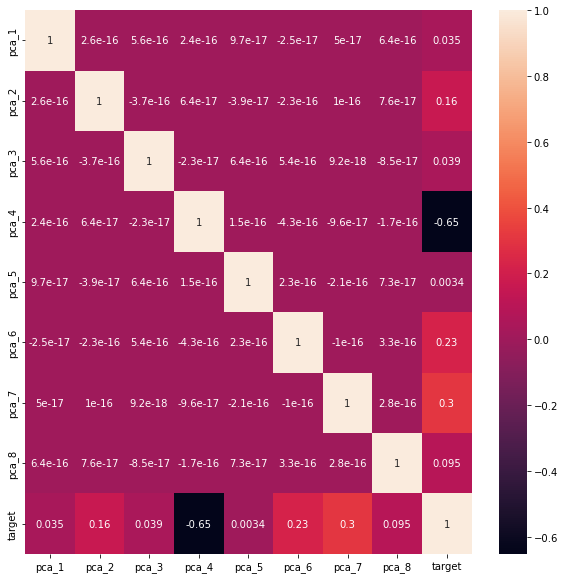

In [37]:
#各主成分とtargetの相関
#各主成分同士は無相関であることが分かる
plt.figure(figsize=(10,10))
sns.heatmap(df_pca_3.corr(), annot=True)
plt.show()

In [38]:
#寄与率
pca_5.explained_variance_ratio_

array([0.25336868, 0.23516245, 0.15888635, 0.12887971, 0.12538195,
       0.0824225 , 0.01020022, 0.00569814])

In [39]:
#累積寄与率
#第５主成分あたりで全体の分散の９割を説明していることが分かる
pca_5.explained_variance_ratio_.cumsum()

array([0.25336868, 0.48853113, 0.64741747, 0.77629718, 0.90167913,
       0.98410164, 0.99430186, 1.        ])

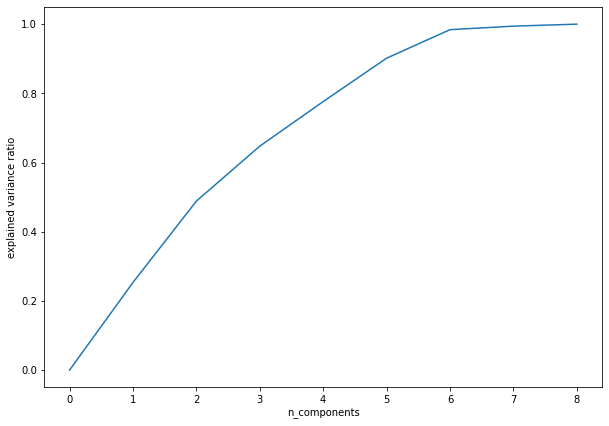

In [40]:
#累積寄与率をグラフ化
plt.figure(figsize=(10,7))
#np.hstack 配列を横（列方向）に結合
plt.plot(np.hstack([0, pca_5.explained_variance_ratio_.cumsum()]))
plt.xlabel('n_components')
plt.ylabel('explained variance ratio')
plt.show()

In [41]:
#因子負荷量(特徴量に係る係数)を特徴量ごとにデータフレーム格納
pca_components_2 = pd.DataFrame(pca_5.components_, columns=df_train_3.loc[:,'MedInc':'Longitude'].columns)
pca_components_2

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.077462,0.007318,0.439142,0.399996,-0.171783,-0.014644,0.568364,-0.536974
1,0.229879,-0.260786,0.546687,0.501850,0.100626,0.002621,-0.374011,0.422387
2,0.218222,-0.627551,-0.063999,-0.191848,0.650375,0.157727,0.192600,-0.180824
3,-0.885294,-0.109898,-0.046402,0.338144,0.283207,0.004918,0.062214,0.059846
4,-0.002603,0.222936,0.029852,0.050922,0.008078,0.972669,-0.022761,0.011807
5,0.149818,0.683931,0.095054,0.086854,0.675226,-0.169410,-0.042069,-0.082551
6,0.169238,-0.081035,-0.530662,0.531566,-0.031676,0.003246,-0.431797,-0.461698
7,-0.242271,-0.044846,0.458814,-0.379875,-0.013170,0.008959,-0.554415,-0.526165


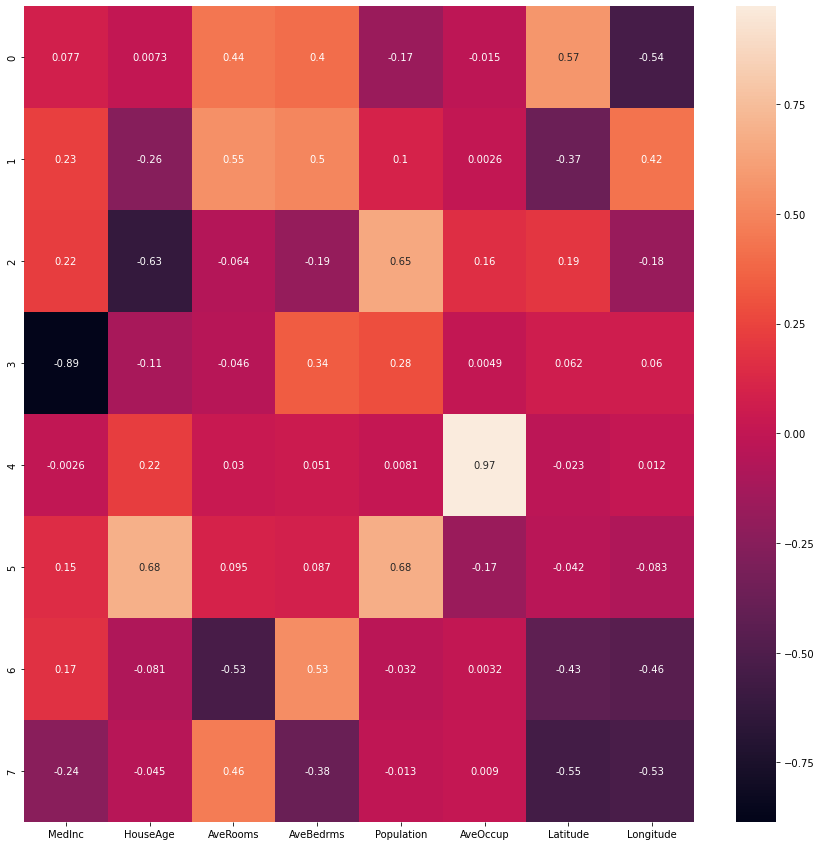

In [42]:
#因子負荷量をヒートマップ化し主成分と特徴量の関係を調べる 0=第一主成分
plt.figure(figsize=(15,15))
sns.heatmap(pca_components_2, annot=True)
plt.show()

In [43]:
#第５主成分までを抽出
x_train_pca = x_pca[:1000,:5]
x_test_pca = x_pca[1000:,:5]
print(x_pca[:1000,:5].shape, x_pca[1000:,:5].shape)

(1000, 5) (19640, 5)


In [44]:
lr_pca = LinearRegression()
lr_pca.fit(x_train_pca, y_train)

LinearRegression()

In [45]:
y_train_pred_pca = lr_pca.predict(x_train_pca)
print('RMSE_train_pca', mean_squared_error(y_train, y_train_pred_pca, squared=False))

RMSE_train_pca 0.811703069465103


In [46]:
y_test_pred_pca = lr_pca.predict(x_test_pca)
print('RMSE_test_pca', mean_squared_error(y_test, y_test_pred_pca, squared=False))

RMSE_test_pca 1.0199176165753883


⇒RMSE_train_pca 0.811703069465103に対してRMSE_test_pca 1.0199176165753883とRMSEはよりその差が開いた。  
⇒変数削減により汎化性能が上昇するかと思われたが逆に低下した  
※ちなみに選択する主成分の数を増やすとよりその差が開く  
仮説  
・外れ値も除去したほうが良かった？  
・元の特徴量は８個とそんなに多くないのでより特徴量が多いデータでなら変わる？  
・他のモデル（決定木系）なら汎化性能の上昇が狙える？(各主成分とtargetの間に相関がみられるわけではないので線形回帰は不適合？)

### LightGBM 10分割交差検証によりRMSE算出  
特徴量：x_pca  第５主成分まで  
目的変数：y

In [54]:
scoring='neg_root_mean_squared_error'

params = {'reg_alpha': [0.0001, 0.003, 0.1],
          'reg_lambda': [0.0001, 0.1],
             'num_leaves': [2, 3, 4, 6],
             'colsample_bytree': [0.4, 0.7, 1.0],
             'subsample': [0.4, 1.0],
             'subsample_freq': [0, 7],
             'min_child_samples': [0, 2, 5, 10],
             'n_estimators':[5000,10000]
             }


In [61]:
x_pca[:,:5].shape
y.shape

(20640,)

In [62]:
%%time
#ランダムサーチによるハイパラ探索

rscv = RandomizedSearchCV(gbm.LGBMRegressor(boosting_type='gbdt',random_state=2),
                         param_distributions=params,
                         scoring=scoring,
                         cv=5, random_state=3
                         )
rscv.fit(x_pca[:,:5], y)

Wall time: 2min 29s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=2),
                   param_distributions={'colsample_bytree': [0.4, 0.7, 1.0],
                                        'min_child_samples': [0, 2, 5, 10],
                                        'n_estimators': [5000, 10000],
                                        'num_leaves': [2, 3, 4, 6],
                                        'reg_alpha': [0.0001, 0.003, 0.1],
                                        'reg_lambda': [0.0001, 0.1],
                                        'subsample': [0.4, 1.0],
                                        'subsample_freq': [0, 7]},
                   random_state=3, scoring='neg_root_mean_squared_error')

In [63]:
rscv.best_params_

{'subsample_freq': 0,
 'subsample': 0.4,
 'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'num_leaves': 3,
 'n_estimators': 5000,
 'min_child_samples': 5,
 'colsample_bytree': 1.0}

In [66]:
print(np.mean(-rscv.best_score_))

0.7363128661349271


In [71]:
cv=KFold(n_splits=10, shuffle=True, random_state=10)
scores=cross_val_score(gbm.LGBMRegressor(boosting_type='gbdt',random_state=99, subsample_freq=0,subsample=0.4,
 reg_lambda=0.1,
 reg_alpha=0.1,
 num_leaves=3,
 n_estimators=5000,
 min_child_samples=5,
 colsample_bytree=1.0),
                       x_pca[:,:5], y,
                       cv=cv,
                       scoring=scoring
                      )

print(np.mean(np.sqrt(-scores)))

0.8570318473053554


⇒10分割交差検証で第5主成分までの特徴量を使ってRMSEを算出した結果RMSE＝0.8570318473053554になった。  
⇒線形回帰だけでなくLightGBMでもその汎化性能が下がった。